<a href="https://colab.research.google.com/github/mshagirov/mshagirov.github.io/blob/master/_notebooks/ML_journal_club_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST HANDWRITTEN DIGIT CLASSIFICATION WITH PYTORCH

This notebook follows the [`TORCH.NN`](https://pytorch.org/tutorials/beginner/nn_tutorial.html) tutorial. If you not familiar with `PyTorch`, you can read "[What is PyTorch?](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)" and "[Autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py)" tutorials from "[Deep Learning with PyTorch: a 60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)" to get a quick overview of PyTorch's capabilities.





It is assumed that you are either running this notebook in the [colab](https://colab.research.google.com/github/mshagirov/mshagirov.github.io/blob/master/_notebooks/ML_journal_club_01.ipynb), or you have already downloaded and locally installed[`pytorch`](https://pytorch.org/get-started/locally/) and all the other packaged required to run this notebook (as long as you have pytorch >=1.4, you can install other packages as you go along this notebook)

In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Download and Import the Datasets

In [0]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [3]:
# Training and testing datasets
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

# Comvert to torch tensor
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

print(f'Training set\n# samples : {x_train.shape[0]}\nx shape : {x_train.shape}',
      f'\ny shape : {y_train.shape}')
print(f'\nValidation set\n# samples : {x_valid.shape[0]}\nx shape : {x_valid.shape}')

Training set
# samples : 50000
x shape : torch.Size([50000, 784]) 
y shape : torch.Size([50000])

Validation set
# samples : 10000
x shape : torch.Size([10000, 784])


## Display Samples from "Training" and "Validation" Datasets

* Let's plot some randomly selected examples

In [13]:
np.random.seed(42)
sample_ids = np.random.randint(x_valid.shape[0],size=(5,))
print(f'We will plot samples {sample_ids} from "training" and "validation" datasets.')

We will plot samples [7270  860 5390 5191 5734] from "training" and "validation" datasets.


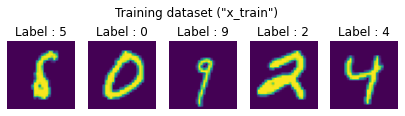

In [11]:
_, axs = plt.subplots(ncols=5,figsize=[7,2])

for ax,t in zip(axs,sample_ids):
  ax.imshow(x_train[t,:].reshape(28,28))
  ax.set_title(f'Label : {y_train[t]}')
  ax.axis(False)
plt.suptitle(f'Training dataset ("x_train")');
plt.show()

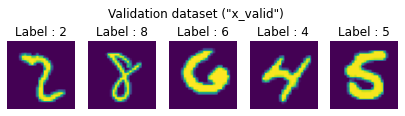

In [14]:
_, axs = plt.subplots(ncols=5,figsize=[7,2])

for ax,t in zip(axs,sample_ids):
  ax.imshow(x_valid[t,:].reshape(28,28))
  ax.set_title(f'Label : {y_valid[t]}')
  ax.axis(False)
plt.suptitle('Validation dataset ("x_valid")');
plt.show()

## Converting Labels to One-hot Encoding in Pytorch

Although some loss functions can handle labels in their raw form (e.g. $y_i$ = "1"), in its general form multiclass classifier requires us to encode target labels (those we provide during the training) into one-hot encoding format. In pytorch, we can use `scatter` function for one-hot encoding MNIST labels.
- Technically, all loss functions internally have to represent target and predicted labels as one-hot encoded vectors.
- E.g. one-hot encoded labels for digits "1" and "5" are as follows
  - "1": `[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]`, and 
  - "5": `[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]`

In [7]:
y_hot = torch.FloatTensor(2,10) # initialise batch labels (done once outside the for-loop)
y_hot.zero_() # set them to zero (for each iter-n)
y_hot.scatter_(1,torch.tensor([[1],[4]]),1) # encode labels "1" and "4"
y_hot

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [8]:
D_in =  28*28
D_out = 10 # number of classes
W = torch.zeros((D_in,D_out))
b = torch.ones((1,D_out))*.1

torch.mm(torch.rand((5,D_in)),W)+b

tensor([[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000]])

## Softmax Classifier

$$C_i = softmax(W\cdot X_i + b)$$

where softmax function with output $C_i\in \mathbb{R}^{K}$ , for $K$ classes

$$softmax(z_i) = \frac{e^{z_i}}{\sum^K_{j=1} e^{z_j}}$$
- $X_i$ input (flattened) image, 784x1 array
- $C_i$ predicted class of the image (label), e.g. "4", $C_i$ is a $K$-dimensional vector (one-hot encoding).
- $W, b$ are learnable model parameters
[[more about softmax and other classifiers](https://cs231n.github.io/linear-classify/#softmax)]

In [0]:
28*28

784

## ConvNets

In [0]:
from torch.nn.functional import conv2d